In [ ]:
!pip install python-dotenv openai matplotlib

Executing AI-interpreted supply chain operations:

Interpreting: 'Process a new order for 5 units of Widget A'
AI Response: **Command Type:** ProcessOrder

**Parameters:**
- Product: Widget A
- Quantity: 5 units

**Explanation:**
- The command is to process a new order for 5 units of Widget A. This means that the existing inventory needs to be adjusted to reflect the deduction of 5 units of Widget A.
Processed command: ProcessOrder with parameters: **Parameters:**
- Product: Widget A
- Quantity: 5 units

**Explanation:**
- The command is to process a new order for 5 units of Widget A. This means that the existing inventory needs to be adjusted to reflect the deduction of 5 units of Widget A.

Interpreting: 'Update the inventory of Widget B to 200 units'
AI Response: Command Type: UpdateInventory

Parameters:
- Item: Widget B
- New Quantity: 200

Response: The inventory of Widget B has been updated to 200 units. The new inventory status is as follows:
{'Widget A': 100, 'Widget B': 200, 

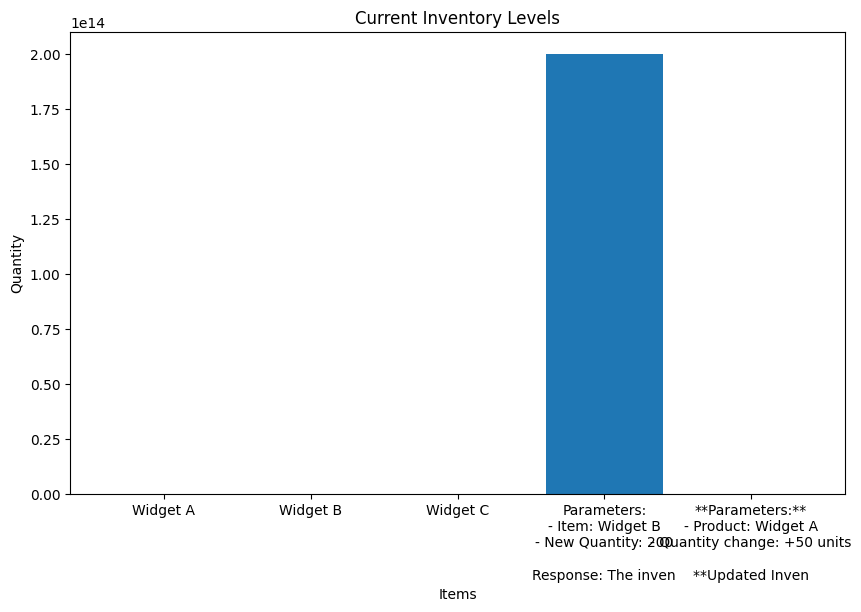

In [4]:
# AI-Enhanced Command Pattern in Supply Chain Management

import abc
from typing import List
from datetime import datetime
import random
from openai import OpenAI
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# Initialize OpenAI client
client = OpenAI()

# 1. Command Interface
class SupplyChainCommand(abc.ABC):
    @abc.abstractmethod
    def execute(self) -> None:
        pass
    
    @abc.abstractmethod
    def undo(self) -> None:
        pass

# 2. Concrete Commands
class ProcessOrderCommand(SupplyChainCommand):
    def __init__(self, order_id: str, inventory: dict):
        self.order_id = order_id
        self.inventory = inventory
        self.processed = False
    
    def execute(self) -> None:
        print(f"Processing order {self.order_id}")
        # Simulate inventory reduction
        for item in self.inventory:
            self.inventory[item] -= 1
        self.processed = True
    
    def undo(self) -> None:
        if self.processed:
            print(f"Undoing order processing for {self.order_id}")
            # Simulate inventory restoration
            for item in self.inventory:
                self.inventory[item] += 1
            self.processed = False

class UpdateInventoryCommand(SupplyChainCommand):
    def __init__(self, item: str, quantity: int, inventory: dict):
        self.item = item
        self.quantity = quantity
        self.inventory = inventory
        self.previous_quantity = None
    
    def execute(self) -> None:
        print(f"Updating inventory for {self.item}")
        self.previous_quantity = self.inventory.get(self.item, 0)
        self.inventory[self.item] = self.quantity
    
    def undo(self) -> None:
        if self.previous_quantity is not None:
            print(f"Undoing inventory update for {self.item}")
            self.inventory[self.item] = self.previous_quantity

class ScheduleShipmentCommand(SupplyChainCommand):
    def __init__(self, shipment_id: str, destination: str):
        self.shipment_id = shipment_id
        self.destination = destination
        self.scheduled = False
    
    def execute(self) -> None:
        print(f"Scheduling shipment {self.shipment_id} to {self.destination}")
        self.scheduled = True
    
    def undo(self) -> None:
        if self.scheduled:
            print(f"Cancelling shipment {self.shipment_id} to {self.destination}")
            self.scheduled = False

# 3. AI-Enhanced Invoker
class AISupplyChainManager:
    def __init__(self):
        self._commands = []
        self._history = []
    
    def add_command(self, command: SupplyChainCommand) -> None:
        self._commands.append(command)
    
    def process_commands(self) -> None:
        for command in self._commands:
            command.execute()
            self._history.append(command)
        self._commands.clear()
    
    def undo_last(self) -> None:
        if self._history:
            command = self._history.pop()
            command.undo()
    
    def interpret_command(self, natural_language_command: str, inventory: dict) -> None:
        prompt = f"""
        Interpret the following supply chain command and provide a structured response:
        Current inventory: {inventory}
        Command: {natural_language_command}
        
        Your response should include the command type (ProcessOrder, UpdateInventory, or ScheduleShipment) and the relevant parameters.
        """
        
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a supply chain management AI assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=100
        )
        
        ai_response = response.choices[0].message.content.strip()
        print(f"AI Response: {ai_response}")  # Debug print
        
        # Attempt to extract command type and parameters from the AI's response
        command_type = None
        parameters = None
        
        if "ProcessOrder" in ai_response:
            command_type = "ProcessOrder"
            parameters = ai_response.split("ProcessOrder", 1)[1].strip()
        elif "UpdateInventory" in ai_response:
            command_type = "UpdateInventory"
            parameters = ai_response.split("UpdateInventory", 1)[1].strip()
        elif "ScheduleShipment" in ai_response:
            command_type = "ScheduleShipment"
            parameters = ai_response.split("ScheduleShipment", 1)[1].strip()
        
        if not command_type or not parameters:
            print(f"Unable to interpret command: {natural_language_command}")
            return
        
        try:
            if command_type == "ProcessOrder":
                order_id = parameters.split()[-1]  # Assume the last word is the order ID
                self.add_command(ProcessOrderCommand(order_id, inventory))
            elif command_type == "UpdateInventory":
                item = parameters.split("to")[0].strip()
                quantity = int(''.join(filter(str.isdigit, parameters)))  # Extract the first number
                self.add_command(UpdateInventoryCommand(item, quantity, inventory))
            elif command_type == "ScheduleShipment":
                shipment_id = f"SHP-{random.randint(1000, 9999)}"  # Generate a random shipment ID
                destination = parameters.split("to")[-1].strip()
                self.add_command(ScheduleShipmentCommand(shipment_id, destination))
            print(f"Processed command: {command_type} with parameters: {parameters}")
        except Exception as e:
            print(f"Error processing command: {e}")
    
    def get_ai_insights(self, inventory: dict) -> str:
        prompt = f"""
        Analyze the following inventory data and provide insights on potential supply chain actions:
        Current inventory: {inventory}
        Provide 3 concise recommendations.
        """
        
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a supply chain management AI assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=750
        )
        
        return response.choices[0].message.content.strip()

# 4. Client code
inventory = {"Widget A": 100, "Widget B": 150, "Widget C": 200}

manager = AISupplyChainManager()

# Simulate AI-interpreted commands
natural_language_commands = [
    "Process a new order for 5 units of Widget A",
    "Update the inventory of Widget B to 200 units",
    "Schedule a shipment of Widget C to New York",
    "Increase Widget A stock by 50 units",
    "Send 10 Widget B to Los Angeles"
]

print("Executing AI-interpreted supply chain operations:")
for command in natural_language_commands:
    print(f"\nInterpreting: '{command}'")
    try:
        manager.interpret_command(command, inventory)
    except Exception as e:
        print(f"Error executing command: {e}")

manager.process_commands()

print("\nCurrent inventory:")
print(inventory)

print("\nGetting AI insights on current inventory:")
insights = manager.get_ai_insights(inventory)
print(insights)

# Visualization
import matplotlib.pyplot as plt

def validate_inventory(inventory):
    """Validate and clean the inventory data."""
    valid_inventory = {}
    for key, value in inventory.items():
        if isinstance(key, str) and isinstance(value, (int, float)):
            valid_inventory[key] = value
        else:
            print(f"Warning: Skipping invalid inventory item: {key}: {value}")
    return valid_inventory

def visualize_inventory(inventory):
    # Validate and clean the inventory data
    valid_inventory = validate_inventory(inventory)
    
    if not valid_inventory:
        print("Error: No valid inventory data to visualize.")
        return

    plt.figure(figsize=(12, 6))
    plt.bar(valid_inventory.keys(), valid_inventory.values())
    plt.title("Current Inventory Levels")
    plt.xlabel("Items")
    plt.ylabel("Quantity")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Before visualization, let's print and validate the inventory
print("Current inventory:")
print(inventory)

# Validate and update the inventory if needed
inventory = validate_inventory(inventory)

print("\nValidated inventory:")
print(inventory)

print("\nVisualizing current inventory:")
visualize_inventory(inventory)